In [5]:
from dask_jobqueue import SLURMCluster
import matplotlib.pyplot as plt 
import glob
import os
import xarray as xr 
import pandas as pd
import numpy as np



cluster = SLURMCluster(
    job_name="Climt1",          # --job-name
    cores=32,                     # Number of cores per task (adjust if needed)
    processes=1,                 # One process per task
    memory="100GB",    # --mem
    walltime="01:15:00",         # --time
    queue="med",               # --partition
    log_directory=".",           # Logs will be saved to the current directory
)


from dask.distributed import Client


cluster.scale(jobs=10)
client = Client(cluster)
client

/home1/nalex2023/.conda/envs/nma/lib/python3.13/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34363 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.42.239.61:34363/status,
Dashboard: http://10.42.239.61:34363/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.42.239.61:37857,Workers: 0
Dashboard: http://10.42.239.61:34363/status,Total threads: 0
Started: Just now,Total memory: 0 B


2025-04-05 17:29:05,514 - tornado.application - ERROR - Uncaught exception GET /workers/ws (163.118.12.163)
HTTPServerRequest(protocol='http', host='10.42.239.61:34363', method='GET', uri='/workers/ws', version='HTTP/1.1', remote_ip='163.118.12.163')
Traceback (most recent call last):
  File "/home1/nalex2023/.conda/envs/nma/lib/python3.13/site-packages/tornado/websocket.py", line 938, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/home1/nalex2023/.conda/envs/nma/lib/python3.13/site-packages/tornado/web.py", line 3301, in wrapper
    return method(self, *args, **kwargs)
  File "/home1/nalex2023/.conda/envs/nma/lib/python3.13/site-packages/bokeh/server/views/ws.py", line 149, in open
    raise ProtocolError("Token is expired. Configure the app with a larger value for --session-token-expiration if necessary")
bokeh.protocol.exceptions.ProtocolError: Token is expired. Configure the app with a larger value for --session-token-expira

In [4]:
client.close()
cluster.close()

In [6]:

filerh = '/home1/nalex2023/main/tropcyc/atlantic_exps3/Datasets/raw/Rh_mid/'

fileu = '/home1/nalex2023/main/tropcyc/atlantic_exps3/Datasets/raw/u_comp/'

filev = '/home1/nalex2023/main/tropcyc/atlantic_exps3/Datasets/raw/v_comp/'

file_sst_sp = '/home1/nalex2023/main/tropcyc/atlantic_exps3/Datasets/raw/surfacePT/'


In [ ]:

def prepro(ds):
    ds_mean = ds.mean(dim='level')
    return ds_mean


dset_rh = xr.open_mfdataset(filerh+'*.nc',chunks={'time':1000},preprocess=prepro,parallel=True).sel(expver=1)#.compute()


In [3]:
dset_rh.to_netcdf('/home1/nalex2023/main/tropcyc/atlantic_exps3/Datasets/raw/RH_MID_2000_2023.nc')

In [12]:



def preprocess(uvdata):
    data = uvdata    
    meanup = data.sel(level=[200,250,300]).mean(dim='level')
    meanlow = data.sel(level=[775,800,925]).mean(dim='level')
    
    shear_c = abs(meanup - meanlow)
    
    return shear_c



dset_u = xr.open_mfdataset(fileu+'*.nc',chunks={'time':400},preprocess=preprocess,parallel=True).sel(expver=1)
dset_v = xr.open_mfdataset(filev+'*.nc',chunks={'time':400},preprocess=preprocess,parallel=True).sel(expver=1)



dset_shear = np.sqrt(dset_u['u']**2 + dset_v['v']**2)

dset_shear = dset_shear.to_dataset(name='shear')

# rechunk the data
dset_shear = dset_shear.chunk({'time':10000, 'latitude': 100, 'longitude': 100}).persist()


In [19]:
dset_shear.to_netcdf('/home1/nalex2023/main/tropcyc/atlantic_exps3/Datasets/raw/SHEAR_2000_2023.nc')

AttributeError: 'tuple' object has no attribute 'size'

In [ ]:
dset_sp = xr.open_mfdataset(file_sst_sp+'*.nc',chunks='auto',parallel=True).sel(expver=1)




<xarray.Dataset> Size: 29GB
Dimensions:    (time: 34671, latitude: 165, longitude: 313)
Coordinates:
  * longitude  (longitude) float32 1kB -83.0 -82.75 -82.5 ... -5.5 -5.25 -5.0
  * latitude   (latitude) float32 660B 43.0 42.75 42.5 42.25 ... 2.5 2.25 2.0
  * time       (time) datetime64[ns] 277kB 2000-06-01 ... 2023-10-03T18:00:00
    expver     int32 4B 1
Data variables:
    sst        (time, latitude, longitude) float64 14GB dask.array<chunksize=(894, 99, 189), meta=np.ndarray>
    sp         (time, latitude, longitude) float64 14GB dask.array<chunksize=(894, 99, 189), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-08 17:04:28 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [16]:
dset_speed.to_netcdf('/home1/nalex2023/main/tropcyc/atlantic_exps3/Datasets/raw/WIND_SPEED_2000_2023.nc')

NameError: name 'dset_speed' is not defined

In [37]:

dset_all = dset_u.copy()
dset_all['v'] = dset_v['v']
dset_all['rh'] = dset_rh['r']

dset_all['sp'] = dset_sst_sp['sp']
dset_all['sst'] = dset_sst_sp['sst']

In [38]:

dset_all['speed'] = np.sqrt(dset_all['u']**2 + dset_all['v']**2)

In [ ]:
dset_all = dset_all.persist()

<xarray.Dataset> Size: 769GB
Dimensions:    (longitude: 341, latitude: 193, level: 6, time: 69594)
Coordinates:
  * longitude  (longitude) float32 1kB -83.0 -82.75 -82.5 ... 1.5 1.75 2.0
  * latitude   (latitude) float32 772B 43.0 42.75 42.5 42.25 ... -4.5 -4.75 -5.0
  * level      (level) int32 24B 200 250 300 775 800 925
  * time       (time) datetime64[ns] 557kB 2000-01-01 ... 2023-10-26T03:00:00
    expver     int32 4B 1
Data variables:
    u          (time, level, latitude, longitude) float64 220GB dask.array<chunksize=(400, 6, 193, 341), meta=np.ndarray>
    v          (time, level, latitude, longitude) float64 220GB dask.array<chunksize=(397, 6, 193, 341), meta=np.ndarray>
    rh         (time, latitude, longitude) float64 37GB dask.array<chunksize=(737, 165, 313), meta=np.ndarray>
    sp         (time, latitude, longitude) float64 37GB dask.array<chunksize=(1444, 165, 313), meta=np.ndarray>
    sst        (time, latitude, longitude) float64 37GB dask.array<chunksize=(1444, 165, 313), meta=np.ndarray>
    speed      (time, level, latitude, longitude) float64 220GB dask.array<chunksize=(397, 6, 193, 341), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-30 03:16:40 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [40]:
dset_all_new = dset_all.resample(time='6h').mean()

KeyboardInterrupt: 

In [37]:
dset_all_6h = dset_all.resample(time='6h').mean()

/home1/nalex2023/.conda/envs/nma/lib/python3.13/site-packages/xarray/groupers.py:487: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.index_grouper = pd.Grouper(


KeyboardInterrupt: 

In [32]:
dset_all['speed'] = np.sqrt(dset_all['u']**2 + dset_all['v']**2)


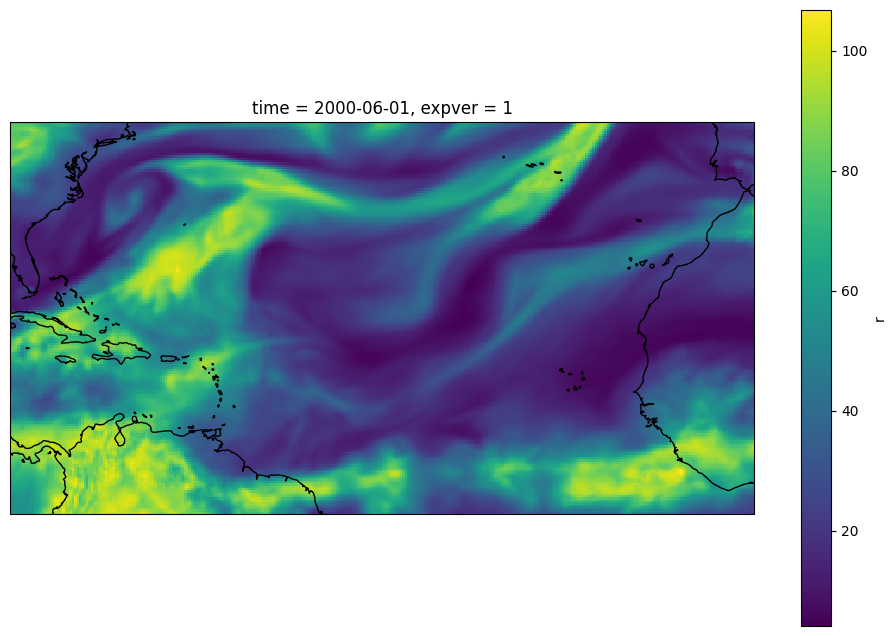

In [19]:
import cartopy.crs as ccrs

fig,ax = plt.subplots(figsize=(12, 8),subplot_kw={'projection': ccrs.PlateCarree()})
dset_rh.isel(time=0).r.plot(ax=ax,transform=ccrs.PlateCarree(),cmap='viridis')

ax.coastlines()